## Importing the required libraries 

In [ ]:
import numpy as np
import h5py
#data file type h5py
import time
import copy
from random import randint


### Loading the MNIST data

In [ ]:
MNIST_data = h5py.File('/content/drive/My Drive/assignment week 1/assignment_4/MNISTdata.hdf5', 'r')
x_train = np.float32(MNIST_data['x_train'][:])
y_train = np.int32(np.array(MNIST_data['y_train'][:,0]))
x_test = np.float32(MNIST_data['x_test'][:])
y_test = np.int32(np.array(MNIST_data['y_test'][:,0]))
MNIST_data.close()


In [ ]:
x_train.shape

(60000, 784)

## Implementation of stochastic gradient descent algorithm
I have defined an class NN to represent the model and contain its parameters.
The parameters are initialised randomly at first and then by using stochastic gradient descent and logistic regression parameters are updated.

The class has other 8 methods to handle model fitting and testing

In [ ]:
#Implementation of stochastic gradient descent algorithm

class NN:
    first_layer = {}
    second_layer = {}

    def __init__(self, inputs, hidden, outputs):
        """
        initialize the model parameters, including the first and second layer 
        parameters and biases

        Argument:
        inputs -- size of the input layer
        hidden -- size of the hidden layer
        outputs -- size of the output layer
        
        """

        self.first_layer['para'] = np.random.randn(hidden,inputs) / np.sqrt(num_inputs)
        self.first_layer['bias'] = np.random.randn(hidden,1) / np.sqrt(hidden)
        self.second_layer['para'] = np.random.randn(outputs,hidden) / np.sqrt(hidden)
        self.second_layer['bias'] = np.random.randn(outputs,1) / np.sqrt(hidden)
        self.input_size = inputs
        self.hid_size = hidden
        self.output_size = outputs

    def __activfunc(self,Z,type = 'ReLU',deri = False):
        """
        Implements the activation functions in numpy
        
        Arguments:
        Z -- numpy array of any shape
        type -- string object 
        Returns:
        Activations as per the type, same shape as Z
        """

        if type == 'ReLU':
            if deri == True:
                return np.array([1 if i>0 else 0 for i in np.squeeze(Z)])
            else:
                return np.array([i if i>0 else 0 for i in np.squeeze(Z)])
        elif type == 'Sigmoid':
            if deri == True:
                return 1/(1+np.exp(-Z))*(1-1/(1+np.exp(-Z)))
            else:
                return 1/(1+np.exp(-Z))
        elif type == 'tanh':
            if deri == True:
                return 
            else:
                return 1-(np.tanh(Z))**2
        else:
            raise TypeError('Invalid type!')

    def __Softmax(self,z):
        """
        Implements the softmax activation in numpy
        
        Arguments:
        z -- numpy array of any shape
        
        Returns:
        output of Softmax(z), same shape as z
        """

        return 1/sum(np.exp(z)) * np.exp(z)

    def __cross_entropy_error(self,v,y):
        """
        Implements the cross entropy error in numpy
        
        Arguments:
        v -- Probability vector to label predictions, shape (1, number of examples)
        y -- true "label" vector, shape (1, number of examples)
        Returns:
        output of cross entropy error function
        """

        return -np.log(v[y])

    def __forward(self,x,y):
        """
        Implements the forward propagation step in numpy      
        
        Arguments:
        x -- data, numpy array of shape (input size, number of examples)
        y -- true "label" vector, shape (1, number of examples)
        Returns:
        dic -- dictionary comprised of 
                Z -- product of input layera and first layer parameters
                H -- result of Activation function on Z
                U -- product of H and second layer parameters
                f_X -- predict_list
                error -- cross entropy error between predict_list and y
        """      
        # implement the forward computation, calculation of prediction list and error
        Z = np.matmul(self.first_layer['para'],x).reshape((self.hid_size,1)) + self.first_layer['bias']
        H = np.array(self.__activfunc(Z)).reshape((self.hid_size,1))
        U = np.matmul(self.second_layer['para'],H).reshape((self.output_size,1)) + self.second_layer['bias']
        predict_list = np.squeeze(self.__Softmax(U))
        error = self.__cross_entropy_error(predict_list,y)
        
        dic = {
            'Z':Z,
            'H':H,
            'U':U,
            'f_X':predict_list.reshape((1,self.output_size)),
            'error':error
        }
        return dic

    def __back_propagation(self,x,y,f_result):
        """
        Implements the back propagation step in numpy      
        
        Arguments:
        x -- data, numpy array of shape (input size, number of examples)
        y -- true "label" vector, shape (1, number of examples)
        dic_result -- dictionary comprised of 
                Z -- product of input layera and first layer parameters
                H -- result of Activation function on Z
                U -- product of H and second layer parameters
                f_X -- predict_list
                error -- cross entropy error between predict_list and y

        Returns:
        grad -- dictionary comprised of gradients 
        """      

        # implement the back propagation process, compute the gradients
        E = np.array([0]*self.output_size).reshape((1,self.output_size))
        E[0][y] = 1
        dU = (-(E - f_result['f_X'])).reshape((self.output_size,1))
        db_2 = copy.copy(dU)
        dC = np.matmul(dU,f_result['H'].transpose())
        delta = np.matmul(self.second_layer['para'].transpose(),dU)
        db_1 = delta.reshape(self.hid_size,1)*self.__activfunc(f_result['Z'],deri=True).reshape(self.hid_size,1)
        dW = np.matmul(db_1.reshape((self.hid_size,1)),x.reshape((1,784)))

        grad = {
            'dC':dC,
            'db_2':db_2,
            'db_1':db_1,
            'dW':dW
        }
        return grad

    def __optimize(self,b_result, learning_rate):
        """
        updates the parameters of the layers 

        Arguments:
        b_result -- dictionary comprising of gradients as a result of back propagation step
        learning_rate -- numeric value
        

        """
        # update the hyperparameters
        self.second_layer['para'] -= learning_rate*b_result['dC']
        self.second_layer['bias'] -= learning_rate*b_result['db_2']
        self.first_layer['bias'] -= learning_rate*b_result['db_1']
        self.first_layer['para'] -= learning_rate*b_result['dW']

    def __loss(self,X_train,Y_train):
        """
        implement the loss function of the training set
        Arguments : 
            X_train -- data, numpy array of shape (input size, number of examples)
            Y_train -- labels, numpy array of shape (1, number of examples)
        
        Returns:
            loss -- the loss of the network/error
        """    
        loss = 0
        for n in range(len(X_train)):
            y = Y_train[n]
            x = X_train[n][:]
            loss += self.__forward(x,y)['error']
        return loss

    def testing(self,X_test, Y_test):
    """
    Arguments : 
    X_test -- testing data, numpy array of shape (input size, number of examples)
    Y_test -- testing labels, numpy array of shape (1, number of examples)

    Returns:
    accuracy
    """

        # test the model on the training dataset
        total_correct = 0
        for n in range(len(X_test)):
            y = Y_test[n]
            x = X_test[n][:]
            prediction = np.argmax(self.__forward(x,y)['f_X'])
            if (prediction == y):
                total_correct += 1
        print('Accuarcy Test: ',total_correct/len(X_test))
        return total_correct/np.float(len(X_test))


    def train(self, X_train, Y_train, num_iterations = 1000, learning_rate = 0.5):
        """
        Arguments : 
        X_train -- training data, numpy array of shape (input size, number of examples)
        Y_train -- training labels, numpy array of shape (1, number of examples)
        num_iterations -- number of iterations/epochs

        Returns:
        loss_dict -- Dictionary with loss associated with each iteration
        test_dict -- Dictionary with accuracy on the testing data associated with each step 
        """

        # generate a random list of indices for the training set
        rand_indices = np.random.choice(len(X_train), num_iterations, replace=True)
        
        def l_rate(base_rate, ite, num_iterations, schedule = False):
        # determine whether to use the learning schedule
            if schedule == True:
                return base_rate * 10 ** (-np.floor(ite/num_iterations*5))
            else:
                return base_rate

        count = 1
        loss_dict = {}
        test_dict = {}

        for i in rand_indices:
            f_result = self.__forward(X_train[i],Y_train[i])
            b_result = self.__back_propagation(X_train[i],Y_train[i],f_result)
            self.__optimize(b_result,l_rate(learning_rate,i,num_iterations,True))
            
            if count % 1000 == 0:
                if count % 5000 == 0:
                    loss = self.__loss(X_train,Y_train)
                    test = self.testing(x_test,y_test)
                    print('Trained for {} times,'.format(count),'loss = {}, test = {}'.format(loss,test))
                    loss_dict[str(count)]=loss
                    test_dict[str(count)]=test
                else:
                    print('Trained for {} times,'.format(count))
            count += 1

        print('Training finished!')
        return loss_dict, test_dict



In [ ]:
# set the number of iterations
num_iterations = 200000
# set the base learning rate
learning_rate = 0.01
# number of inputs
num_inputs = 28*28
# number of outputs
num_outputs = 10
# size of hidden layer
hidden_size = 300


## Data fitting, training and accuracy evaluation


In [ ]:
model = NN(num_inputs,hidden_size,num_outputs)
cost_dict, tests_dict = model.train(x_train,y_train,num_iterations=num_iterations,learning_rate=learning_rate)
accu = model.testing(x_test,y_test)


Trained for 1000 times,
Trained for 2000 times,
Trained for 3000 times,
Trained for 4000 times,
Accuarcy Test:  0.8796
Trained for 5000 times, loss = 24416.97308485007, test = 0.8796
Trained for 6000 times,
Trained for 7000 times,
Trained for 8000 times,
Trained for 9000 times,
Accuarcy Test:  0.9122
Trained for 10000 times, loss = 17757.611042307217, test = 0.9122
Trained for 11000 times,
Trained for 12000 times,
Trained for 13000 times,
Trained for 14000 times,
Accuarcy Test:  0.9284
Trained for 15000 times, loss = 14777.011318073084, test = 0.9284
Trained for 16000 times,
Trained for 17000 times,
Trained for 18000 times,
Trained for 19000 times,
Accuarcy Test:  0.9286
Trained for 20000 times, loss = 14514.765315746337, test = 0.9286
Trained for 21000 times,
Trained for 22000 times,
Trained for 23000 times,
Trained for 24000 times,
Accuarcy Test:  0.9316
Trained for 25000 times, loss = 13765.954332850939, test = 0.9316
Trained for 26000 times,
Trained for 27000 times,
Trained for 280

## Plotting Loss

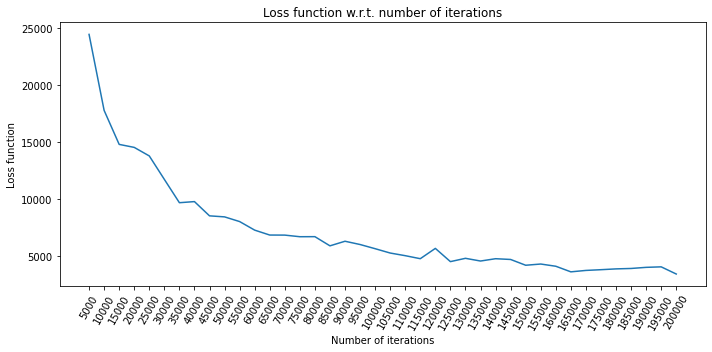

In [ ]:
# plotting the loss function and test accuracy corresponding to the number of iterations
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
plt.plot(list(cost_dict.keys()),list(cost_dict.values()))
plt.ylabel('Loss function')
plt.xlabel('Number of iterations')
plt.xticks(rotation=60)
plt.title('Loss function w.r.t. number of iterations')
plt.tight_layout()
plt.show()



### Plotting accuracy on test data

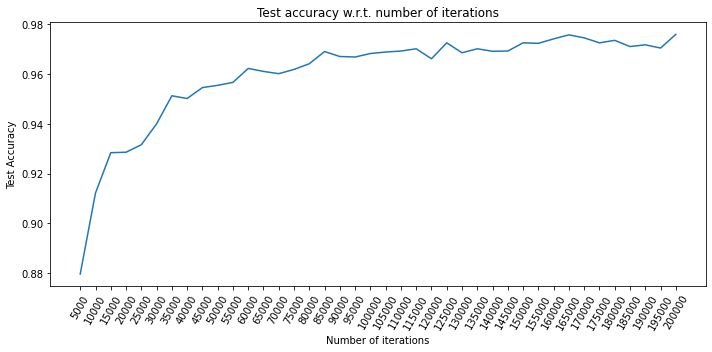

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(list(tests_dict.keys()),list(tests_dict.values()))
plt.ylabel('Test Accuracy')
plt.xlabel('Number of iterations')
plt.xticks(rotation=60)
plt.title('Test accuracy w.r.t. number of iterations')
plt.tight_layout()
plt.show()
